In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

!pip install box2d-py

     |████████████████████████████████| 448 kB 8.1 MB/s 


In [2]:
import argparse
import gym
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import torchvision

from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import math
import random 
import pandas as pd 
import seaborn as sns

import gym
from gym import wrappers
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [5]:
env = gym.make('LunarLanderContinuous-v2')
state = env.reset()
state

array([-0.00595245,  1.3985053 , -0.6029336 , -0.55178946,  0.00690418,
        0.13657331,  0.        ,  0.        ], dtype=float32)

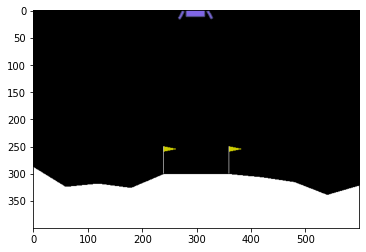

In [6]:
# 
screen = env.render(mode='rgb_array')
plt.imshow(screen)

In [7]:
actions_map = {0: [0.5, 0.0], 1: [-1, -0.75] , 2: [-1, 0.75] , 3: [0.5, -0.75] , 4: [0.5, 0.75]}
num_of_actions = len(actions_map)
num_of_actions

5

In [8]:
ActionLog = namedtuple('ActionLog', ['log_prob'])


In [9]:
class Net(nn.Module):
    def __init__(self, state_size, num_of_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, num_of_actions)

    def forward(self, state):
        x = self.fc1(state)
        #x = self.bn1(x)
        x = F.leaky_relu(x)
        
        x = self.fc2(x)
        #x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        x = F.leaky_relu(x)
        x =  self.fc4(x)

        return F.softmax(x, dim=1)
    
    def init_weights(self):

      torch.nn.init.xavier_uniform_(self.fc1.weight)
      torch.nn.init.xavier_uniform_(self.fc2.weight)
      torch.nn.init.xavier_uniform_(self.fc3.weight)
      torch.nn.init.xavier_uniform_(self.fc4.weight)

      return self
    


class Agent:
    def __init__(self, net):
        self.net = net 

        self.saved_actions = []
        self.rewards = []

    def run_on_state(self, state):

        state = state.to(device)
        actions_prob = self.net(state)
      
        return  actions_prob

In [10]:
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.2
EPS_DECAY = 6000
steps_done = 0

In [12]:
def select_action(state):
  
    global steps_done
    steps_done += 1

    state_tensor = torch.Tensor([state]).to(device)
    probs = model.run_on_state(state_tensor)
    categorical = Categorical(probs)

    action = categorical.sample()
    model.saved_actions.append(ActionLog(categorical.log_prob(action)))


    return action.item()

In [13]:
def train_on_episode():

    saved_actions = model.saved_actions
    policy_losses = [] 
    returns = []

    step_total_r = 0
    for step_immediate_rewars in reversed(model.rewards):
        step_total_r = step_immediate_rewars + GAMMA * step_total_r
        returns.insert(0, step_total_r)

    returns = torch.tensor(returns).to(device)

    returns = (returns - returns.mean()) / (returns.std() + eps)

    prev_state = None
    prev_action = None
    for (saved_action, step_total_r) in zip(saved_actions, returns):

        # policy_losses.append(-saved_action.log_prob * step_total_r)
        policy_losses.append(-saved_action.log_prob * step_total_r)


    optimizer.zero_grad()
  
    loss = torch.cat(policy_losses).sum()

    loss.backward()
    optimizer.step()
    
    model.rewards = []
    model.saved_actions = []

    return loss

In [14]:
net = Net(state.shape[0] , num_of_actions).init_weights().to(device)

model = Agent(net)

optimizer = optim.SGD(net.parameters(), lr=0.0001)

eps = np.finfo(np.float32).eps.item()

In [ ]:
episodes_durations = []
episodes_rewards = []
steps_done = 0
net.train()



for episode_number in count(1):

  if episode_number > 5000:
    break
  if episode_number % 50 == 0:
    print('episode_number {}'.format(episode_number))

  state = env.reset()


  #not_allowed_actions = None
  episode_reward = 0.0
  for step_number in range(1, 10000):
    action_id = select_action(state)

    action = actions_map[action_id]

    state, reward, done, _ = env.step(action)
    episode_reward += reward
    
    model.rewards.append(reward)

    if done:
      episodes_durations.append(step_number)
      episodes_rewards.append(episode_reward)
      break

  train_on_episode()

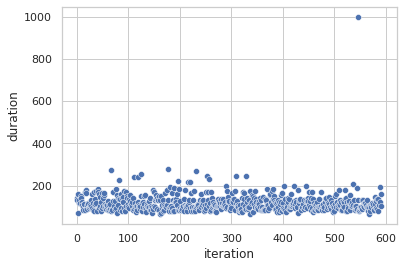

In [16]:
durations_df = pd.DataFrame([(iteration, duration) for (iteration, duration) in enumerate(episodes_durations)], columns =["iteration", "duration"])
sns.set_theme(style="whitegrid")

sns.scatterplot(data=durations_df, x="iteration", y="duration")


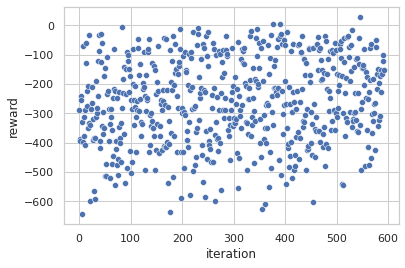

In [17]:
durations_df = pd.DataFrame([(iteration, reward) for (iteration, reward) in enumerate(episodes_rewards)], columns =["iteration", "reward"])
sns.set_theme(style="whitegrid")

sns.scatterplot(data=durations_df, x="iteration", y="reward")


In [26]:
# state_tensor = torch.Tensor(state).unsqueeze(0).to(device)

# state_tensor.shape 
# #probs = model.run_on_state(state_tensor)
# state = env.reset()
state_tensor = torch.Tensor([state]).to(device)
net(state_tensor).sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [1]:
net.eval()

state = env.reset()
screen = env.render(mode='rgb_array')
plt.imshow(screen)

NameError: ignored